This is a rough draft with brainstorming and ideas for the Micaeli quest.

House Micaeli is associated with the Mark of Detection, which allows them to sense hidden threats like poison and discover the intent behind others' words and actions. They are effectively counterintelligence experts or spycatchers -- they have a stronghold called the tower of interrogation where they extract secrets, and every trained Micaeli member is adept at telling whether someone is lying or telling the truth.

This feature will be exploited in the main quest for House Micaeli. Their lie detection powers come from eldritch speech which can process audio and detect features that are indicative of lying or truthfulness. We will demo some simple signal processing tools to illustrate this, before using it to motivate studying the sounds of the invading abberations.

Source material includes https://github.com/calebmadrigal/FourierTalkOSCON, https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/fftpack.html, and https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/signal.html. Rough outline of curriculum:

(Intermediate: want to include spectrograms, audio recording, some noise filtering and transformations, and a learning problem of classification given different properties; ultimately need to justify understanding what the abberants are saying; todo is figure out how to record audio in notebook). Possible task: overlay several different screeches, slightly offset, and ask them to predict how many there are. Another possibly ask: give examples of ready and irritated, and ask them to program a rule to predict which is which [probably too hard]. TODO is brainstorm and insert more programming tasks).

* Tie-in with Micaeli lie detection and motivation of problem. Explanation of physical nature of sound waves (pressure/density fluctuations). Example of two different sounds (either two instruments, maybe two speech samples of a man and a woman). Lateral thinking activity: brainstorm as many characteristics of sound as you can (that is, properties that can be used to distinguish between two sounds). Good responses include pitch, volume, duration, inclusion of many different pitches, time variation of pitch and volume, etc.
* Intuitive explanation of Fourier transform and the frequency domain. Not sure if this should be motivated with the superposition principle. Maybe put the mathematical definition but this is intimidating. Demonstration for one of the given sounds. First coding task goes here -- probably something simple like obtaining the FFT and printing out the frequency with the highest spectral power density (literally run through a list keeping the largest element). Perhaps explain timbre comes from relative strengths of different frequency peaks.
* Plot interruption. Reveal the secret that House Micaeli wants to use its technology for analyzing audio to study the abberants. Perhaps this can be used to predict their behavior or, if they have a language, even to understand what they're saying!
* First audio sample of an abberrant (probably just a zergling waveform). Ask them to analyze with the tools they have. Possibly tell them about the spectrogram to see time dependence (better because it doesn't bucket together all of the modes).
* 

Ideas to include:
* spectrogram (mentioned above)
* recording their own audio sample; if we use the contrast between male and female voices, can also hand them a machine learning object and have it predict whether they have a male or female voice, although this is only impressive if highly accurate
* realtime (scope, scrolling spectrogram), perhaps via the interact() structure
* refining and adding more features, testing each of them to see whether they're different between their classes, coming up witha  rule
* one of the students has a special power which gives him knowledge of additional, specialized audio features to extract, like the ones listed here (http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf)
* need to think of integration with another team
* filtering example?

In [5]:
from scipy.io import wavfile
f = "../../audio/drone_annoyance1.wav"
rate, x = wavfile.read(f)

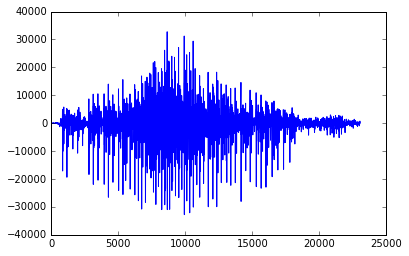

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(x)

In [9]:
import IPython
from IPython import display

IPython.display.Audio(x, rate=rate)

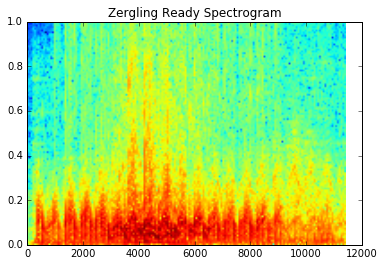

In [7]:
plt.specgram(x); plt.title("Zergling Ready Spectrogram")

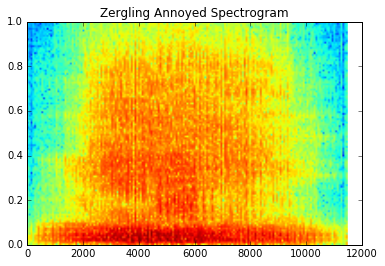

In [10]:
from scipy.io import wavfile
f2 = "../../audio/drone_acknowledgement1.wav"
rate2, x2 = wavfile.read(f2)

IPython.display.Audio(x2, rate=rate2)

plt.specgram(x2); plt.title("Zergling Annoyed Spectrogram")

We want to design a __classifier__, which is a function that takes in an array of audio values as input and decides whether the input correspond to an angry abberant or not as output.

The first step in creating a classifier is deciding what features of the input are relevant, and how to encode those features. For example, we might think that the average volume of an audio sample is an important feature -- perhaps angry samples will tend to be louder on average.

In [51]:
vol1 = first.mean()
vol2 = second.mean()

print vol1, vol2

168.840398826 167.559109149


It seems that the average volume of our samples are quite similar. How about the standard deviation?

In [53]:
std1 = first.std()
std2 = second.std()

print std1, std2

21.1956953208 19.8072894786


This is sllightly more useful, but it seems that volume will not be entirely informative.

What about the frequencies of the audio samples? Perhaps an irritated sample will tend to be higher in pitch.

In [62]:
import numpy as np
from math import sqrt
print first
fft_output = np.fft.rfft(first)
print fft_output.shape
magnitude_only = [sqrt(i.real**2 + i.imag**2)/len(fft_output) for i in fft_output]
frequencies = [(i*1.0/num_samples)*sample_rate for i in range(num_samples/2+1)]

setup_graph(x_label='frequency (in Hz)', y_label='amplitude', title='frequency domain')
plot(frequencies, magnitude_only, 'r')

[[ 167.35765755  172.36897758  177.63581188 ...,  169.56211556
   166.64741057  175.71106035]
 [ 166.304102    166.92595844  167.98468836 ...,  169.08421815  160.4352833
   175.73235436]
 [ 164.11505173  161.61742142  171.1181586  ...,  169.80528485
   161.92298331  175.70724572]
 ..., 
 [ 123.48327333  120.97430732  119.38515352 ...,  112.24481348
   127.47516613  120.8398513 ]
 [ 124.47584344  121.68230166  119.8032455  ...,  123.605356    127.57735138
   120.35006761]
 [ 125.17973518  113.40659339  122.47431957 ...,  122.86986346
   129.38755551  120.28900933]]
(513L, 24L)


TypeError: only length-1 arrays can be converted to Python scalars

In [21]:
import scipy.signal
f, t, Sxx = scipy.signal.spectrogram(x2)

In [36]:
""" This work is licensed under a Creative Commons Attribution 3.0 Unported License.
    Frank Zalkow, 2012-2013 """

import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    
""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
    
    return newspec, freqs

""" plot spectrogram"""
def get_matrix(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    return np.transpose(ims)

def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    samplerate, samples = wav.read(audiopath)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()

In [27]:
first = get_matrix("../../audio/drone_acknowledgement1.wav")
second = get_matrix("../../audio/drone_annoyance1.wav")

C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


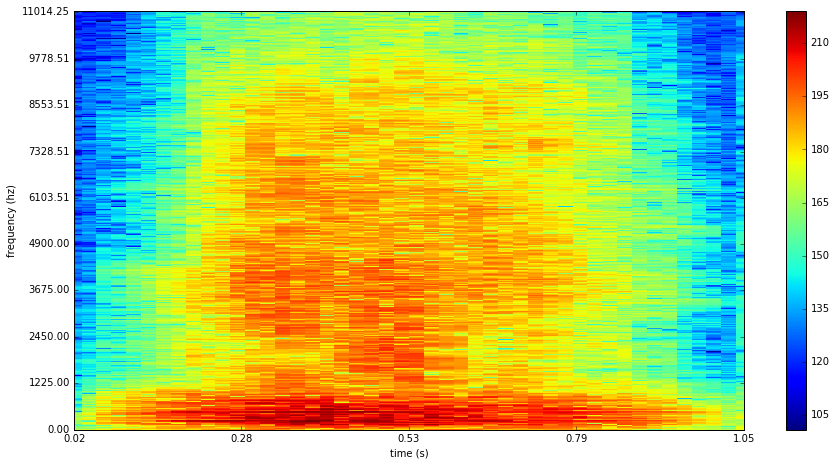

In [38]:
plotstft("../../audio/drone_acknowledgement1.wav")

C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cferko\Anaconda2\lib\site-packages\ipykernel\__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


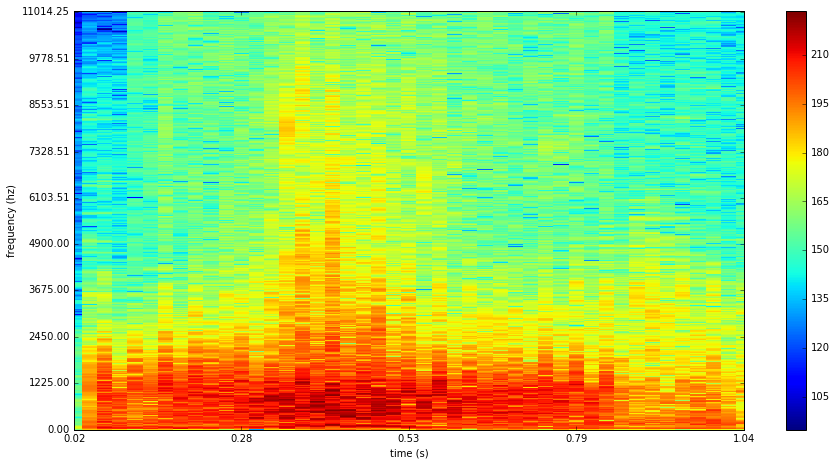

In [39]:
plotstft("../../audio/drone_annoyance1.wav")

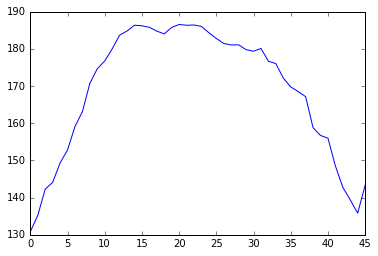

In [47]:
first_means = first.mean(axis=0)
plt.plot(first_means)

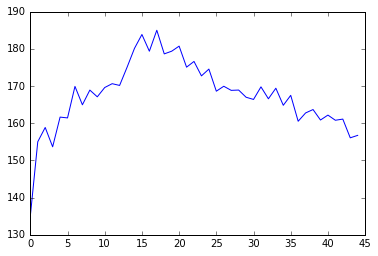

In [48]:
second_means = second.mean(axis=0)
plt.plot(second_means)

In [50]:
print first.max()
print second.max()

218.992923448
223.276377974
